In [1]:
from model import NSFrozenLake
from amalearn.agent import AgentBase
from draw_policy import draw_policy
from plots import plot_total_episode_rewards, plot_regret
from find_max_reward import find_max_reward

import matplotlib.pyplot as plt
import numpy as np

from CONFIG import *
EPISODES = 2000

In [2]:
class Agent(AgentBase):
    
    def __init__(self, id, environment, discount, epsilon, alpha, actions, episodes=1000):
        
        self.environment = environment
        self.i_limit, self.j_limit = 4, 4
        self.actions = actions
        self.epsilon = epsilon
        self.start_epsilon = epsilon
        self.alpha = alpha
        self.discount = discount
        self.episodes = episodes
        
        self.Q = {}
        self.init_Q()
        
        self.b_policy = {}
        self.target_policy = {}
        self.update_policies()
        
        super(Agent, self).__init__(id, environment)
        
    def init_Q(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                for a in self.actions:
                    if (i, j) == (3, 3):
                        self.Q[((i, j), a)] = 0
                    else:
                        self.Q[((i, j), a)] = np.random.rand()
        
    def update_state_b_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.b_policy[state] = np.zeros(len(self.actions))+(self.epsilon/len(self.actions))
        self.b_policy[state][max_q_idx] += (1-self.epsilon)
                    
    def update_state_t_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.target_policy[state] = np.zeros(len(self.actions))
        self.target_policy[state][max_q_idx] = 1
                    
    def update_policies(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                self.update_state_b_policy((i, j))
                self.update_state_t_policy((i, j))
                    
    def sarsa(self):
        
        total_rewards = []
        for epoch in range(REPS):
            
            self.reset()
            episode_rewards = []
            for e in range(self.episodes):
                
                rewards = []
                state = self.environment.reset()
                action, next_state, reward, done = self.take_action(state)
                while True:
                    
                    rewards.append(reward)
                    next_action, next_next_state, next_reward, next_done = self.take_action(next_state)
                    self.Q[(state, action)] += \
                        self.alpha*(reward+self.discount*self.Q[(next_state, next_action)]-self.Q[(state, action)])
                    self.update_state_b_policy(state)
                    state = next_state; action = next_action;
            
                    if done:
                        break
                        
                    next_state = next_next_state; reward = next_reward; done = next_done;
                       
                episode_rewards.append(sum(rewards))
                
                if (e+1)%10 == 0:
                    self.epsilon *= 0.99
                    
            self.environment.reset()
            total_rewards.append(episode_rewards)
            
        return total_rewards
            
    def n_step_tree_backup(self, n):
        
        total_rewards = []
        for epoch in range(REPS):
            
            self.reset()
            episode_rewards = []
            for e in range(self.episodes):
                
                state = self.environment.reset()
                rewards, states, actions = [], [state], []
                T = 10000
                for t in range(T):
                    if t < T:
                        action, next_state, reward, done = self.take_action(states[-1])
                        states.append(next_state); rewards.append(reward); actions.append(action)
                        if done:
                            T = t + 1
                    th = t + 1 - n
                    if th >= 0:
                        if t + 1 >= T:
                            g = rewards[T-1]
                        else:
                            backup = sum([self.b_policy[states[t+1]][a]*self.Q[(states[t+1], a)] for a in self.actions])
                            g = rewards[t] + self.discount*backup
                        for k in range(min(t, T-1), th+1, -1):
                            backup = sum([self.b_policy[states[k]][a]*self.Q((states[k], a)) for a in self.actions is a != actions[k]])
                            g = R[k-1]+self.discount*backup + self.discount*self.b_policy[state[k]][actions[k]]*g
                            
                        self.Q[(states[th], actions[th])] += self.alpha*(g - self.Q[(states[th], actions[th])])
                        self.update_state_t_policy(states[th])
                        self.update_state_b_policy(states[th])
                        
                    if th == T-1:
                        break
                   
                episode_rewards.append(sum(rewards))
                
                if (e+1)%40 == 0:
                    self.epsilon *= 0.99
                    
            self.environment.reset()
            total_rewards.append(episode_rewards)
            
        return total_rewards
        
        
    def take_action(self, state):
        
        action = np.random.choice(self.actions, p=self.b_policy[state])
        next_state, reward, done, _ = self.environment.step(action)
        
        return action, next_state, reward, done
    
    def reset(self):
        
        self.init_Q()
        self.update_policies()
        self.epsilon = self.start_epsilon

In [3]:
environment = NSFrozenLake(studentNum=STUDENT_NUM)

In [4]:
max_expected_reward = find_max_reward(environment)

In [5]:
agent = Agent('1', environment, DISCOUNT, EPSILON, LEARNING_RATE, ACTIONS, episodes=EPISODES)
rewards1 = agent.sarsa()

In [6]:
environment.render()
draw_policy(agent.b_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
→|↓|←|←
→|↓|←|↓
→|→|↓|↓
→|→|→|↻


In [7]:
agent = Agent('1', environment, DISCOUNT, EPSILON, LEARNING_RATE, ACTIONS, episodes=EPISODES)
rewards2 = agent.n_step_tree_backup(2)

In [8]:
environment.render()
draw_policy(agent.b_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
→|↓|↓|←
→|↓|↓|↑
→|→|→|↓
↑|↑|↑|↻


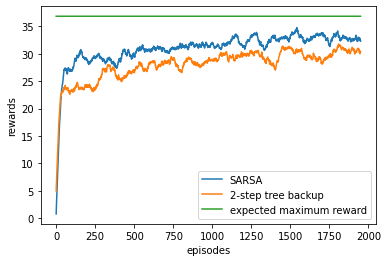

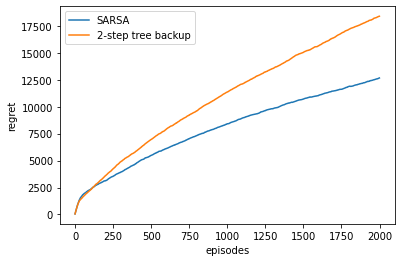

In [9]:
plot_total_episode_rewards(
    rewards1, rewards2, max_expected_reward, 
    'SARSA', '2-step tree backup', window_size=50
)
plot_regret(rewards1, rewards2, max_expected_reward, 'SARSA', '2-step tree backup')